# Clustered Feature Importance

The goal of these notebook is demostrate the Clustered Feature Imporatance, a feature importance method suggested by **Dr. Marcos Lopez de Prado** in the [paper](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595) and the book Machine Learning for Asset Managers. The aim of CFI is to cluster similar features and apply the feature importance analysis at the cluster level. This way clusters are mutually dissimilar and the method is tends tame the substitution effect and  by using information theory along we can also reduce the multicollinearity of the dataset.

In [1]:
# General Imports 
import warnings

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, log_loss
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection._split import KFold

# Import MlFinLab tools
import mlfinlab as ml
from mlfinlab.util.generate_dataset import generate_classification_dataset 
from mlfinlab.clustering.feature_clusters import get_feature_clusters
from mlfinlab.cross_validation.cross_validation import  ml_cross_val_score
from mlfinlab.feature_importance.importance import (mean_decrease_impurity, mean_decrease_accuracy,
                                         plot_feature_importance)
from mlfinlab.clustering.onc import get_onc_clusters

**Clustered Feature Importance or CFI algorithm can be implemented in a two step process as mentioned in the book.**


## Step - 1 : Features Clustering

As first step we need to generate the clusters or subsets of features we want to analyse with feature importance methods. This can be done using feature cluster module of mlfinlab. It uses various parameters to generating feature clusters as in the book.

* The algorithm projects the observed features into a metric space by applying a dependence matric function either correlation based or information theory based. Information-theoretic metrics have the advantage of recognizing redundant features that are the result of nonlinear combinations of informative features (i.e. multicollinearity). 
* Next, we need to determine the optimal number of clusters. The user can either specify the number cluster to use, this will apply a hierarchical clustering on the defined distance matrix of dependence matrix for a given linkage method for clustering, or the user can use the ONC algorithm which uses K-Means clustering, to automate the task of either getting the optimal number of clusters or get both optimal number of clusters and cluster compositions. 

But the *caveat* of these process is that some silhouette scores may be low due one feature being a combination of multiple features across clusters. This is a problem, because ONC cannot assign one feature to multiple clusters. Hence, the following transformation may help reduce the multicollinearity of the system:

In [2]:
# Generating a synthetic dataset for testing 

# We generate 40 features, 5 informative  ('I_') , 30 redudent ('R_') and rest (5) noisy ('N_') features
# with 10000 rows of samples 
# Redundent features are those which share large amount of information among each other and also with informative features 
# That is the redudent features are those with substitution effect
X, y = generate_classification_dataset(n_features=40, n_informative=5, n_redundant=30, n_samples=300, sigma=0.1)

In [3]:
X.head()

,I_0,I_1,I_2,I_3,I_4,N_0,N_1,N_2,N_3,N_4,...,R_20,R_21,R_22,R_23,R_24,R_25,R_26,R_27,R_28,R_29
0,-1.190681,3.067433,0.056526,4.198353,3.375259,-1.380431,-0.535915,0.430771,-0.149892,-1.006037,...,4.032898,-1.277112,4.247799,-1.169280,0.215365,4.254398,-1.149460,2.926274,4.281190,4.160899
1,-2.067875,2.933737,-2.114145,1.623102,1.739627,-0.821550,-1.548254,0.531975,1.260569,-0.100394,...,1.615671,-2.144987,1.717919,-2.165171,-2.083629,1.632902,-2.145137,2.844792,1.736000,1.681491
2,-0.785862,1.033466,-2.049684,-0.947498,0.922567,-0.400349,-1.472323,0.913202,2.211304,-1.797456,...,-0.817045,-0.818460,-0.832955,-0.826001,-2.002935,-0.934014,-0.792357,0.965418,-1.037404,-0.937125
3,-2.884212,0.859477,-1.299015,1.947025,0.425276,-1.063433,-0.679593,-0.564318,0.227346,1.614250,...,2.011698,-2.825724,1.875941,-2.975237,-1.344048,2.050588,-2.874507,1.033147,1.904382,1.851256
4,-1.072359,2.913237,-1.255727,3.105956,1.758165,1.008597,0.527597,-0.723929,-1.119628,-0.796775,...,3.032228,-1.200990,3.131588,-1.011762,-1.370074,3.041803,-1.177914,2.840352,3.062696,2.885029


In [4]:
# Now we get the feature clusters
dep_matrix = 'linear' # Linear correlation base dependence matric

# The n_cluster is set to None for getting the Optimal Number of Clusters using ONC Algorithm
clusters = get_feature_clusters(X, dependence_metric=dep_matrix, distance_metric=None, linkage_method=None, n_clusters=None)

No feature/s found with low silhouette score. All features belongs to its respective clusters


In [5]:
clusters

[['I_3', 'R_2', 'R_3', 'R_4', 'R_6', 'R_20', 'R_22', 'R_25', 'R_28', 'R_29'],
 ['I_0', 'R_1', 'R_9', 'R_10', 'R_14', 'R_17', 'R_21', 'R_23', 'R_26'],
 ['I_1', 'R_5', 'R_13', 'R_15', 'R_16', 'R_18', 'R_27'],
 ['I_4', 'R_0', 'R_8', 'R_11', 'R_19'],
 ['I_2', 'R_7', 'R_12', 'R_24'],
 ['N_0', 'N_1', 'N_2', 'N_3', 'N_4']]

As we can see that algorithm have not detected any features with low silhoutte score. So, there is no need replace the features with their residuals*. Now, that we have identified the number clusters (six in this case) and composition of features with in each cluster, we can move to the next step.
<br> ( *This will be discussed in the later part of this notebook)

## Step - 2 : Clustered Importance

Clustered Feature Importance can be implemented by simply passing the feature clusters obtained in Step-1 to the **clustered_subsets** argument of the MDI or MDA feature importance algorithm. We can apply MDI and MDA on groups of similar features, rather than on individual features and obtain the importance of the cluster as whole instead of individual features. This way we can anlayse how mutually dissimilar clusters interact with model and possibly isolate the noisy/non-infomative clusters.

In [7]:
# Setup for feature importance algorithm 
# We define a classifier 
clf_base = DecisionTreeClassifier(criterion='entropy', max_features=1, class_weight='balanced', min_weight_fraction_leaf=0)
clf = BaggingClassifier(base_estimator=clf_base, n_estimators=1000, max_features=1., max_samples=1.,
                        oob_score=True, n_jobs=-1)

# Fit the classifier
fit = clf.fit(X,y)

# Setting up cross-validation generator
# Use Purged K-Fold generator while using it on real financial dataset to avoid leakage
cv_gen = KFold(n_splits=3)
oos_score = ml_cross_val_score(clf, X, y, cv_gen=cv_gen, sample_weight_train=None, scoring=log_loss).mean()

### Clustered MDI

We compute the clustered MDI as the sum of the MDI values of the features that constitute that cluster. If there is one feature per cluster, then MDI and clustered MDI are the same.

In [8]:
clustered_mdi_imp = mean_decrease_impurity(clf,X.columns,clustered_subsets=clusters)

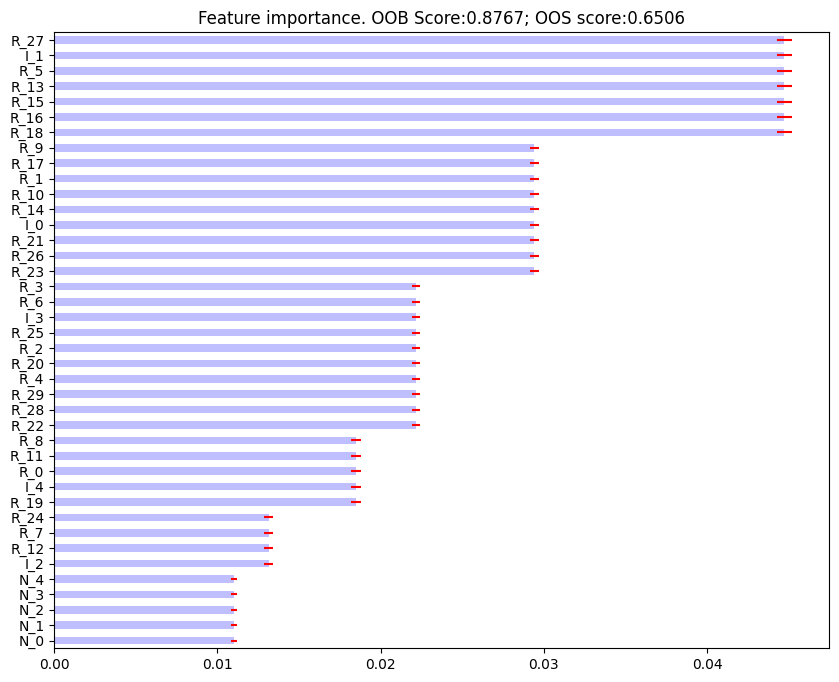

In [9]:
plot_feature_importance(clustered_mdi_imp,oob_score=clf.oob_score_, oos_score=oos_score,
                        save_fig=True, output_path='images/clustered_mdi.png')

As expected the clusters of non-informative features are given the least importnance and the clusters with redundent and informative features are placed above the noise cluster. This is very usefull for detecting features that are non-informative without the presence of some other features within the same cluster. 

### Clustered MDA

As an extension to normal MDA to tackle multi-collinearity and (linear or non-linear) substitution effect. Its implementation was also discussed by Dr. Marcos Lopez de Prado in the Clustered Feature Importance [Presentaion Slides](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595)

In [10]:
clustered_mda_imp = mean_decrease_accuracy(clf, X, y, cv_gen=cv_gen, clustered_subsets=clusters,
                                           scoring=log_loss)

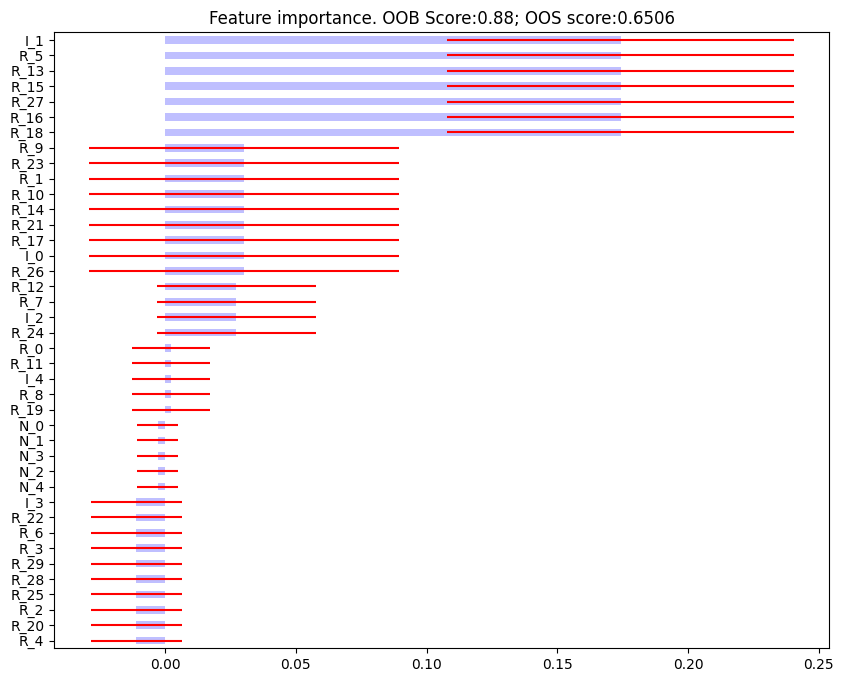

In [11]:
plot_feature_importance(clustered_mda_imp,oob_score=clf.oob_score_, oos_score=oos_score,
                        save_fig=True, output_path='images/clustered_mda.png')

The clustered MDA has also correctly identified the noisy cluster and placed it below. 

## The Caveat
Now that we saw how to implement the CFI with MDI and MDA, we have to discuss the *caveat* of normal ONC algorithm that was mentioned in the Step -1 of this notebook.

To understand the caveat of the normal ONC algorithm, we need a understanding of how it works. ONC finds the optimal number of clusters as well as the composition of those clusters, where each feature belongs to one and only one cluster. Features that
belong to the same cluster share a large amount of information, and features that belong to different clusters share only a relatively small amount of information. 
<br>The consistency composition of the clusters are determined by the [silhouette score](https://en.wikipedia.org/wiki/Silhouette_(clustering)) of the features. The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters. So, there may be some features with low silhouette score and this is a problem, because ONC cannot assign one feature to multiple clusters. 
<br>In this case, the following transformation may help reduce the multicollinearity of the system :

For each cluster $k = 1 . . . K$, replace the features included in that cluster with residual features, so that it do not contain any information outside cluster $k$. That is let $D_{k}$ be the subset of index features $D = {1,...,F}$ included in cluster $k$, where $D_{k}\subset{D}\ , ||D_{k}|| > 0 \ , \forall{k}\ ; \ D_{k} \bigcap D_{l} = \Phi\ , \forall k \ne l\ ; \bigcup \limits _{k=1} ^{k} D_{k} = D$ . Then, for a given feature $X_{i}$ where $i \in D_{k}$, we compute the residual feature $\hat \varepsilon _{i}$ by fitting the following equation for regression -

$$X_{n,j} = \alpha _{i} + \sum \limits _{j  \in \{ \bigcup _{l<k}\ D_{l} \} } \beta _{i,j} X_{n,j} + \varepsilon _{n,i}$$

Where $n = 1,....,N$ is the index of observations per feature. But if the degrees of freedom in the above regression is too low, one option is to use as regressors linear combinations of the features within each cluster by following a minimum variance weighting scheme so that only $K-1$ betas need to be estimated.
This transformation is not necessary if the silhouette scores clearly indicate that features belong to their respective clusters.

In [13]:
corr0, clusters, silh = get_onc_clusters(X.corr(), repeat=3)

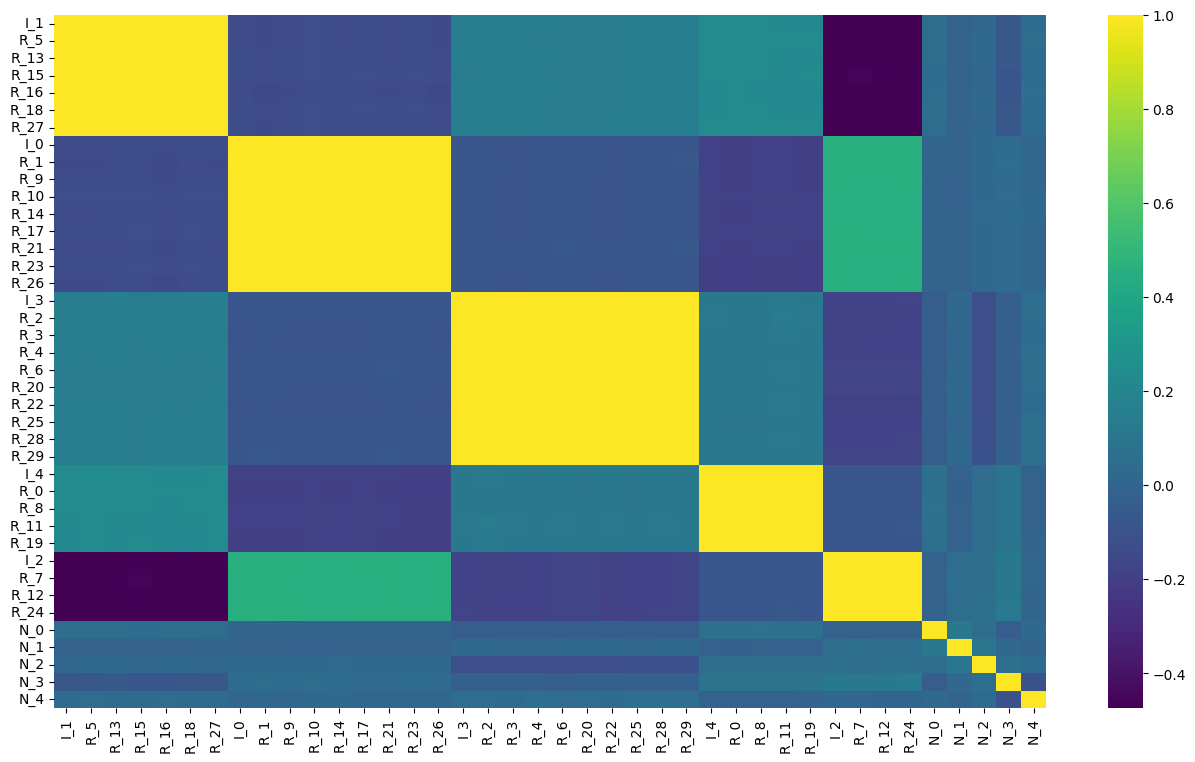

In [14]:
plt.figure(figsize=(16,9))
sns.heatmap(corr0,cmap='viridis');

In [15]:
silh

I_0     0.967060
I_1     0.971442
I_2     0.968779
I_3     0.967646
I_4     0.967828
N_0     0.397551
N_1     0.408642
N_2     0.399203
N_3     0.348225
N_4     0.399773
R_0     0.960601
R_1     0.961510
R_2     0.964759
R_3     0.964740
R_4     0.963693
R_5     0.965974
R_6     0.964468
R_7     0.962852
R_8     0.961993
R_9     0.963944
R_10    0.961964
R_11    0.961309
R_12    0.962111
R_13    0.968565
R_14    0.963400
R_15    0.964309
R_16    0.966906
R_17    0.963206
R_18    0.966481
R_19    0.959920
R_20    0.962587
R_21    0.963582
R_22    0.964852
R_23    0.962238
R_24    0.960258
R_25    0.964021
R_26    0.963647
R_27    0.966849
R_28    0.965566
R_29    0.963364
dtype: float64

As we can see there is very low correlation among clusters. Hence, we need not to tranform anything in this dataset. The silhouette score also confirm the same, as there no features have silhouette score below zero.

Now let us artificially generate a dataset that can introduce features with low silhouette score. Here the sigmaStd argument of generate_classification_dataset will help us to generate a dataset with high substitution effect.

In [16]:
# We set the value of sigmaStd to 4 to introduce high substitution effect
X_, y_ = generate_classification_dataset(n_features=40, n_informative=5, n_redundant=30, n_samples=1000, sigma=5)

In [ ]:
# Now lets check if we obtained our desired dataset 
corr0, clusters, silh = get_onc_clusters(X_.corr())

In [16]:
clstrs

{0: ['I_1',
  'I_4',
  'N_4',
  'R_5',
  'R_8',
  'R_11',
  'R_13',
  'R_15',
  'R_16',
  'R_18',
  'R_19',
  'R_27'],
 1: ['I_0',
  'I_2',
  'I_3',
  'N_0',
  'N_1',
  'N_2',
  'N_3',
  'R_0',
  'R_1',
  'R_2',
  'R_3',
  'R_4',
  'R_6',
  'R_7',
  'R_9',
  'R_10',
  'R_12',
  'R_14',
  'R_17',
  'R_20',
  'R_21',
  'R_22',
  'R_23',
  'R_24',
  'R_25',
  'R_26',
  'R_28',
  'R_29']}

Now, lets see if there is any features with low silhouette score. If yes then we can correct it with the transformation mentioned above (transformation is appiled automatically).

In [17]:
# This function has built-in detection property that detects the features with low silhouette score
# and corrects it with transformation
clusters = get_feature_clusters(X_, dependence_metric=dep_matrix, distance_metric=None,
                                linkage_method=None, n_clusters=None)

3 feature/s found with low silhouette score Index(['N_0', 'N_4', 'R_0'], dtype='object'). Returning the transformed dataset


We have got the dataset with some features that has some negative silhouette score. Due to this all of noisy features are placed with the informative and redundent feature clusters. **This is the caveat of the ONC algorithm**

In [18]:
clusters

[['I_0', 'N_0', 'R_1', 'R_9', 'R_10', 'R_14', 'R_17', 'R_21', 'R_23', 'R_26'],
 ['I_2',
  'I_3',
  'N_1',
  'N_2',
  'N_3',
  'R_2',
  'R_3',
  'R_4',
  'R_6',
  'R_7',
  'R_12',
  'R_20',
  'R_22',
  'R_24',
  'R_25',
  'R_28',
  'R_29'],
 ['I_1',
  'I_4',
  'N_4',
  'R_0',
  'R_5',
  'R_8',
  'R_11',
  'R_13',
  'R_15',
  'R_16',
  'R_18',
  'R_19',
  'R_27']]

As we can see the composition after transformation has changed and now we have 3 clusters instead of 2. Though this is not perfect but it has done a must better job in clustering than the normal ONC algorithm. Also the get_feature_clusters function can detect the problem of low degree of freedom of the regression model used for generating the residual $\hat \varepsilon _{i}$ for replacing the orginal feature $X_{i}$ as mentioned above.

## Using Hierarchical Clustering 

In [19]:
dist_matrix = 'angular' # Angular distance matric
linkage = 'single' # Linkage method for hierarchical clustering
clusters_ = get_feature_clusters(X, dependence_metric=dep_matrix, distance_metric=dist_matrix,
                                 linkage_method=linkage, n_clusters=None)

No feature/s found with low silhouette score. All features belongs to its respective clusters


In [20]:
clusters_

[['I_0',
  'I_2',
  'R_1',
  'R_7',
  'R_9',
  'R_10',
  'R_12',
  'R_14',
  'R_17',
  'R_21',
  'R_23',
  'R_24',
  'R_26'],
 ['I_1',
  'I_4',
  'R_0',
  'R_5',
  'R_8',
  'R_11',
  'R_13',
  'R_15',
  'R_16',
  'R_18',
  'R_19',
  'R_27'],
 ['I_3',
  'N_0',
  'N_3',
  'R_2',
  'R_3',
  'R_4',
  'R_6',
  'R_20',
  'R_22',
  'R_25',
  'R_28',
  'R_29'],
 ['N_2'],
 ['N_1'],
 ['N_4']]

Using Heirarchical Clustering we get 6 clusters and 3 of them are with only single element and are non-informative features.

## Conclusion

At the end I would like say that the user can use different depedence matric including both correlation based and information theory based metric (like Information Variation which have the advantage of recognizing redundant features that are the result of nonlinear combinations of informative features). Also the user can use different linkage methods for hierarchical clustering or define the number of clusters.

## References

* Paper: https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3517595
* Book: Machine Learning for Asset Managers by Dr. Marcos Lopez De Prado